Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from matplotlib.colors import ListedColormap
from math import inf
from queue import Queue

#### Reprezentacja macierzy NxNxN na macierzy rows^3

In [2]:
def create_3d_matrix(k):
    n = 2 **(3*k)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in [0, 1, -1, 2**(k), -2**(k), 2**(k*2), -2**(k*2)]:
            if i + j >= 0 and i + j < n:
                matrix[i][i + j] = np.random.random()
    return matrix

#### Kompresja macierzy z poprzedniego labolatorium

Struktura drzewa:

In [3]:
class Node:
    def __init__(self):
        self.rows = None
        self.columns = None
        self.matrix = None
        self.rank = None
        self.U = None
        self.D = None
        self.VT = None
        self.children = []

Kompresja:

In [4]:
def split_matrix(X):
    n = X.shape[1]//2
    return X[:n, :n], X[:n, n:], X[n:, :n], X[n:, n:]

def compress(M, r, epsilon):
    if not np.any(M):
        node = Node()
        node.rank = 0
        node.rows, node.columns = M.shape
        return node

    if M.shape[0] <= r + 1 and M.shape[1] <= r + 1:
        node = Node()
        node.rows, node.columns = M.shape
        node.matrix = M
        return node
    
    U, D, VT = svds(M, k= r + 1)
    
    if abs(D[0]) < epsilon:
        node = Node()
        node.rows, node.columns = M.shape
        node.rank = r
        node.U = U[:, 1:]
        node.D = D[1:]
        node.VT = VT[1:]
    
    else:
        M_11, M_12, M_21, M_22 = split_matrix(M)
        node = Node()
        node.rows, node.columns = M.shape
        node.rank = None
        node.children.append(compress(M_11, r, epsilon))
        node.children.append(compress(M_12, r, epsilon))
        node.children.append(compress(M_21, r, epsilon))
        node.children.append(compress(M_22, r, epsilon))
    
    return node

Wizualizacja:

In [5]:
# Macierzy 2D:
def draw_matrix(M, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.spy(M)
    plt.show()

# Skompresowanej macierzy przechowywanej w strukturze drzewa
def create_plot(node):
    if node.rank is not None:
        matrix = np.zeros((node.rows, node.columns))
        if node.rank > 0:
            matrix[:, :node.rank] = 1
            matrix[:node.rank, :] = 1

        return matrix
    
    elif node.matrix is not None:
        return np.ones((node.rows, node.columns))
    
    else:
        return np.vstack((
                np.hstack((create_plot(node.children[0]),
                            create_plot(node.children[1]))),
                np.hstack((create_plot(node.children[2]),
                            create_plot(node.children[3]))),))

def draw_node_matrix(node, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.matshow(create_plot(node), cmap=ListedColormap(['w', 'brown']))        
    plt.show()

#### Algorytm minimum degree

In [6]:
def minimum_degree_permutation(matrix):
    result_matrix = matrix.copy()

    rows, columns = matrix.shape
    adj_matrix = {i:set() for i in range(rows)}

    for i in range(rows):
        for j in range(columns):
            if matrix[i][j] != 0 and i != j:
                adj_matrix[i].add(j)

    permutation = []
    for i in range(rows):
        deg_min = columns + 1
        for v, adj in adj_matrix.items():
            if len(adj) < deg_min:
                v_min = v
                deg_min = len(adj)
        for v in adj_matrix:
            adj_matrix[v] = adj_matrix[v].difference([v_min])
        for u in adj_matrix[v_min]:
            adj_matrix[u] = (adj_matrix[u].union(adj_matrix[v_min].difference([u])))
        adj_matrix.pop(v_min)
        permutation.append(v_min)

    for i in range(len(permutation)):
        if i != permutation[i]:
            result_matrix[i,:] = matrix[permutation[i],:].copy()
    matrix = result_matrix.copy()
    for i in range(len(permutation)):
         if i != permutation[i]:
            result_matrix[:,i] = matrix[:,permutation[i]].copy()
    
    return result_matrix

#### Macierze dla Minimum Degree

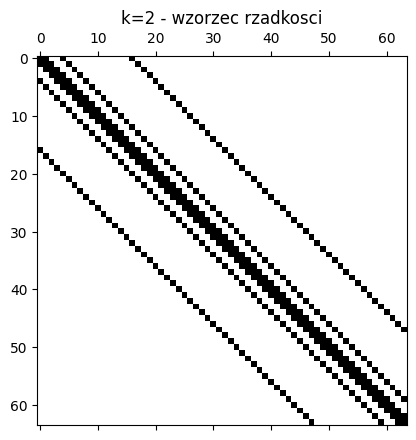

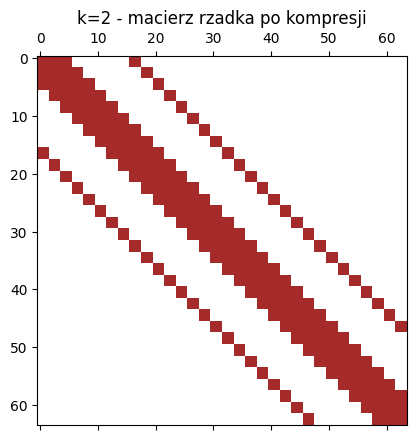

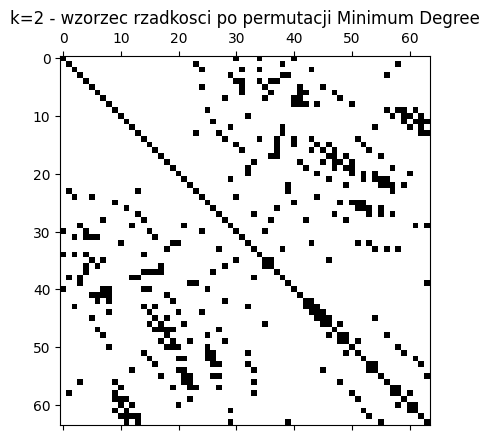

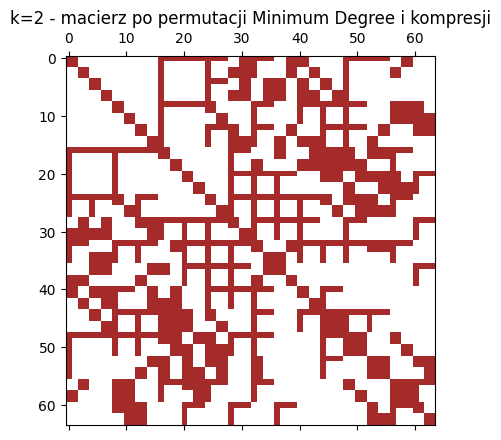

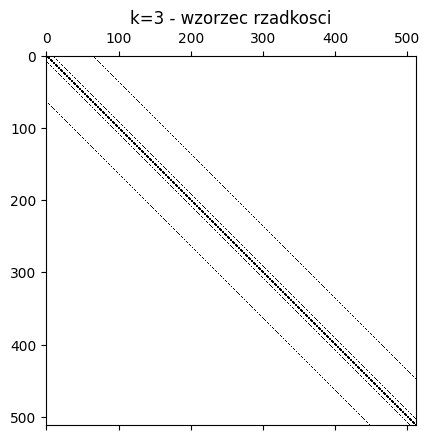

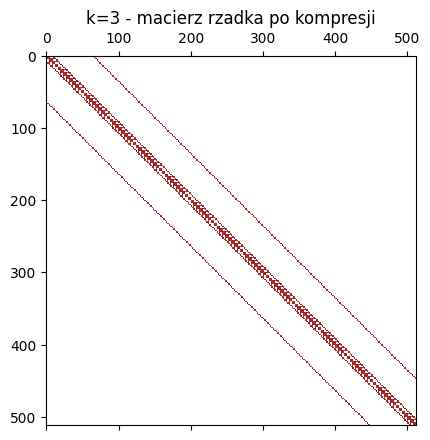

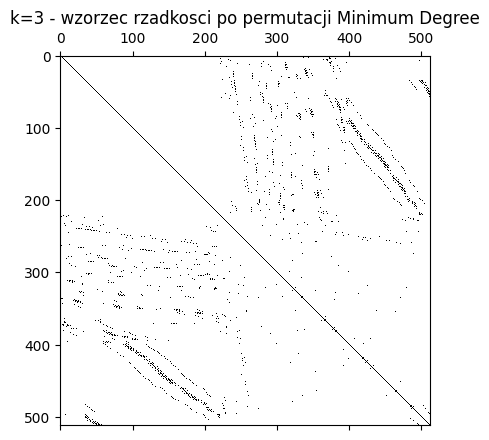

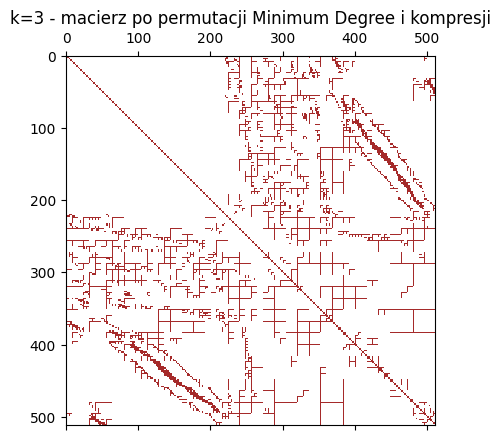

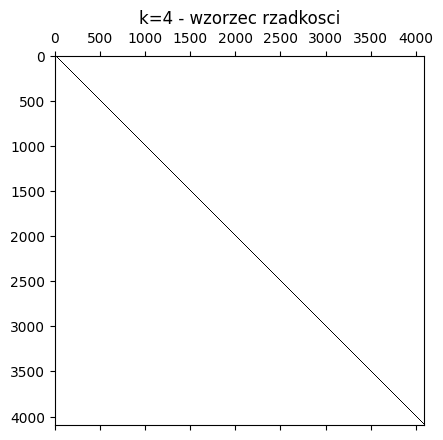

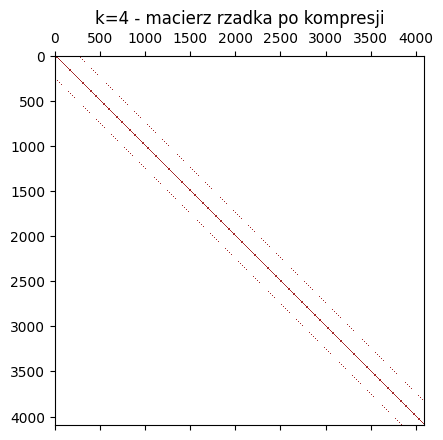

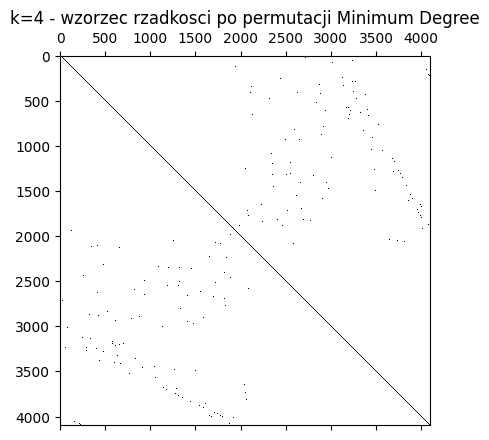

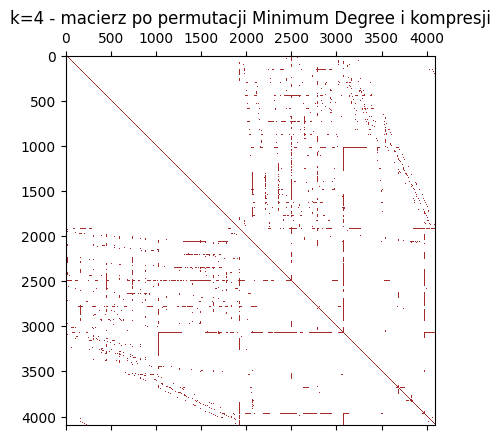

In [7]:
for k in [2, 3, 4]:
    matrix = create_3d_matrix(k)

    draw_matrix(matrix, f"k={k} - wzorzec rzadkosci")
    draw_node_matrix(compress(matrix, 1, 0.0000001),  f"k={k} - macierz rzadka po kompresji")

    matrix_after_permutation = minimum_degree_permutation(matrix)

    draw_matrix(matrix_after_permutation, f"k={k} - wzorzec rzadkosci po permutacji Minimum Degree")
    draw_node_matrix(compress(matrix_after_permutation, 1, 0.0000001), f"k={k} - macierz po permutacji Minimum Degree i kompresji")

#### Algorytm Cuthill-McKee

In [10]:
def cuthill_mckee_permutation(matrix):
    result_matrix = matrix.copy()
    n, m = matrix.shape

    adj_matrix = {i:set() for i in range(n)}
    
    for i in range(n):
        for j in range(m):
            if matrix[i][j] != 0 and i != j:
                adj_matrix[i].add(j)
    deg_min = inf
    
    for v, adj in adj_matrix.items():
        if len(adj) < deg_min:
            v_min = v
            deg_min = len(adj)
    permuattion = []
    pred = [inf for _ in range(n)]
    visited = [False for _ in range(n)]
    pred[v_min] = 0
    queue = Queue()
    queue.put((0, len(adj_matrix[v_min]), v_min))
    
    while not queue.empty():
        _, _, v = queue.get()
        if not visited[v]:
            visited[v] = True
            p = len(permuattion)
            permuattion.append(v)
            for u in adj_matrix[v]:
                if visited[u] == False:
                    if pred[u] > p:
                        pred[u] = p
                    queue.put((pred[u], len(adj_matrix[u]), u))

    for i in range(len(permuattion)):
        if i != permuattion[i]:
            result_matrix[i,:] = matrix[permuattion[i],:].copy()
    matrix = result_matrix.copy()
    for i in range(len(permuattion)):
         if i != permuattion[i]:
            result_matrix[:,i] = matrix[:,permuattion[i]].copy()
    
    return result_matrix


#### Macierze dla permutacji Cuthill-McKee

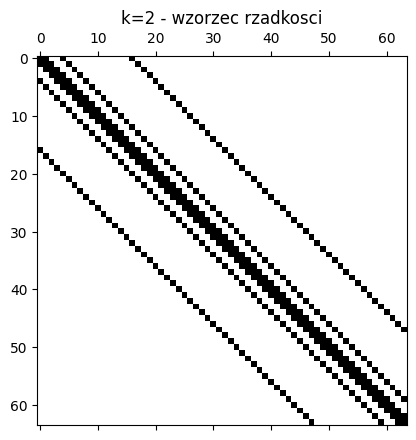

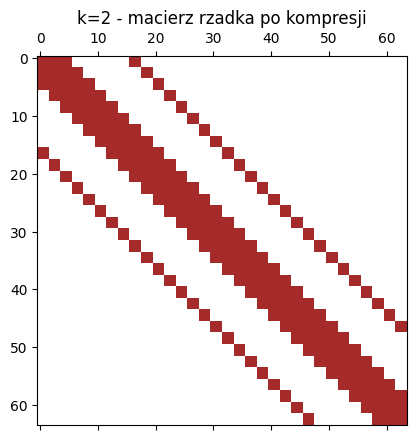

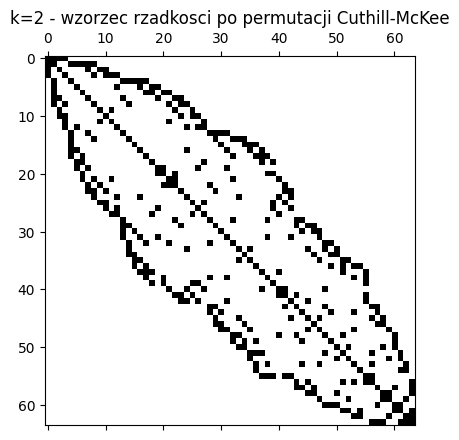

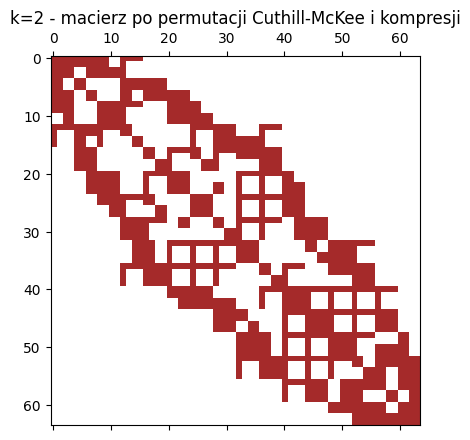

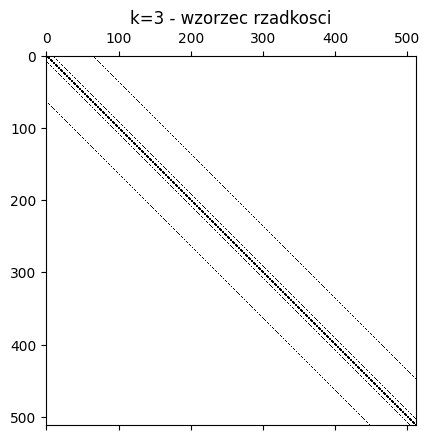

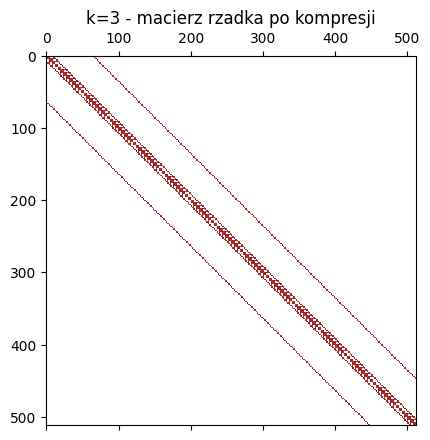

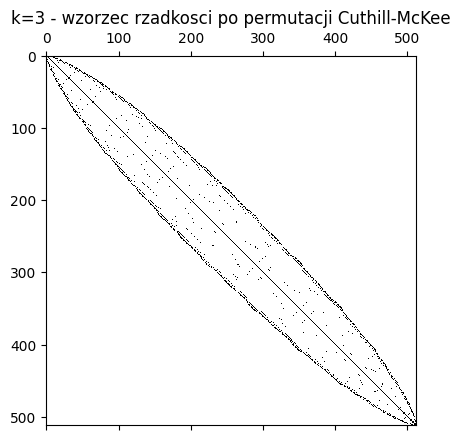

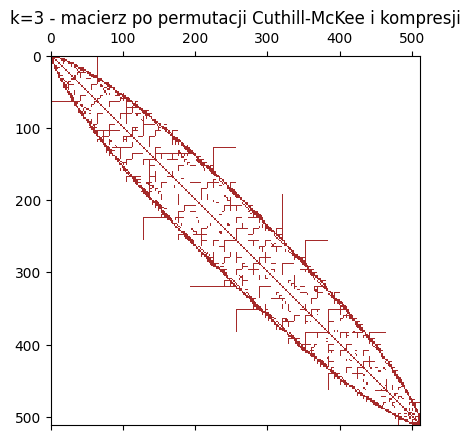

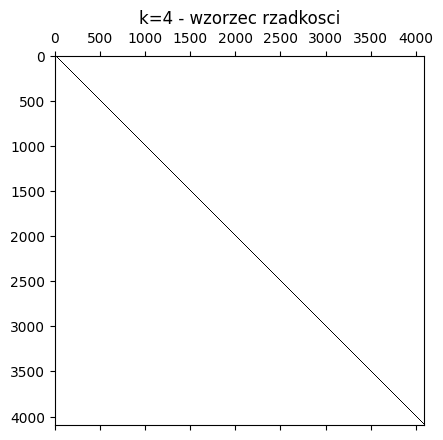

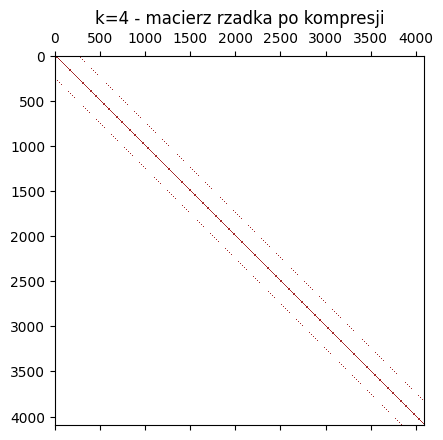

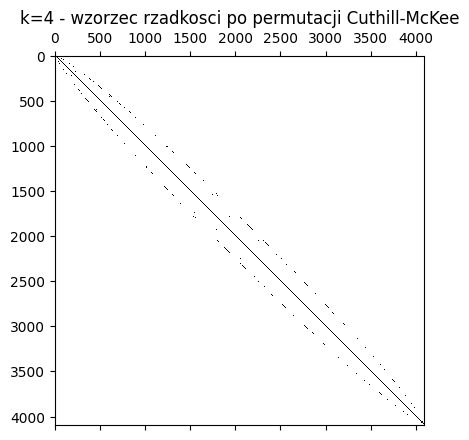

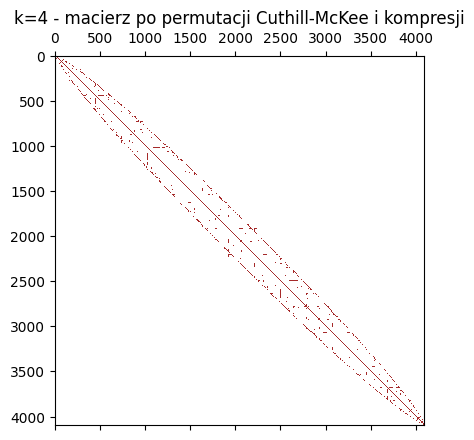

In [11]:
for k in [2, 3, 4]:
    matrix = create_3d_matrix(k)

    draw_matrix(matrix, f"k={k} - wzorzec rzadkosci")
    draw_node_matrix(compress(matrix, 1, 0.0000001),  f"k={k} - macierz rzadka po kompresji")

    matrix_after_permutation = cuthill_mckee_permutation(matrix)

    draw_matrix(matrix_after_permutation, f"k={k} - wzorzec rzadkosci po permutacji Cuthill-McKee")
    draw_node_matrix(compress(matrix_after_permutation, 1, 0.0000001), f"k={k} - macierz po permutacji Cuthill-McKee i kompresji")

#### Reversed Cuthill-McKee

In [12]:
def reversed_cuthill_mckee_permuatation(matrix):
    return cuthill_mckee_permutation(matrix)[::-1]

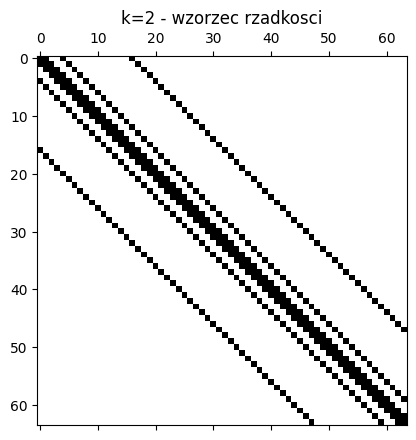

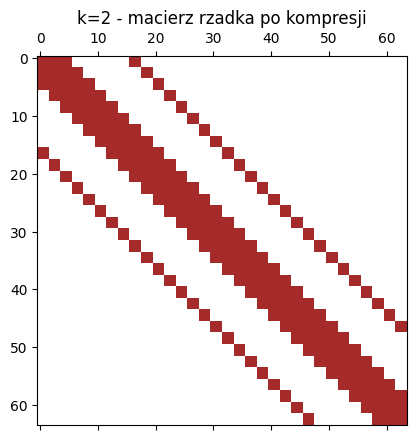

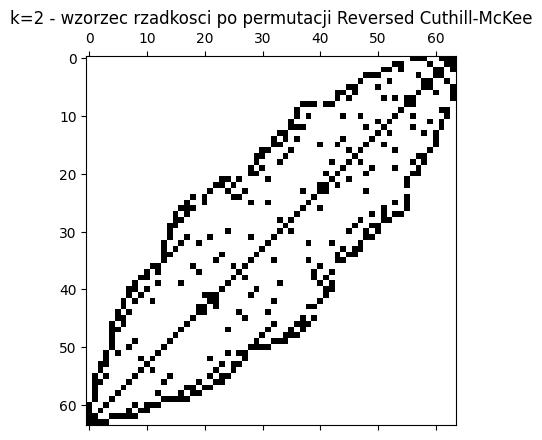

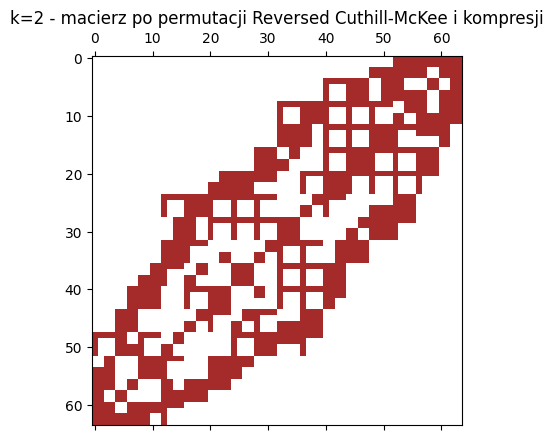

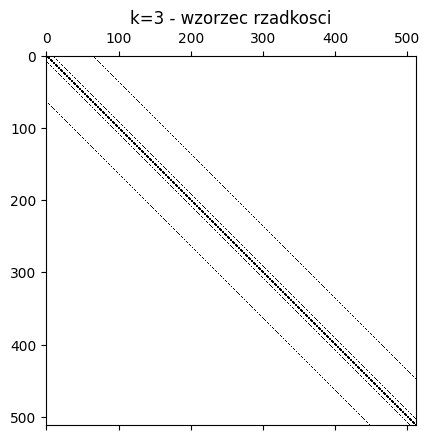

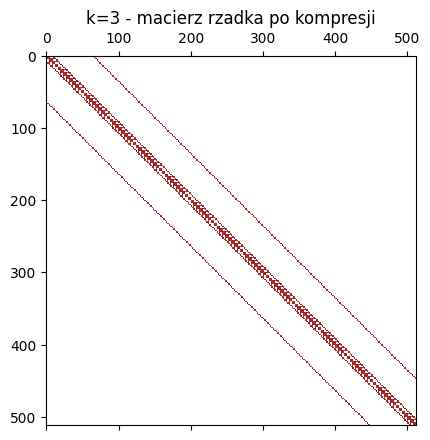

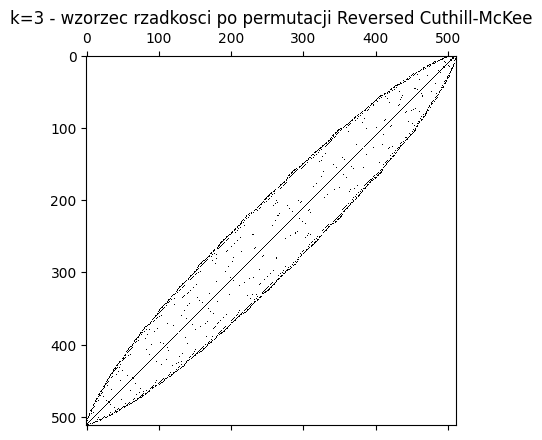

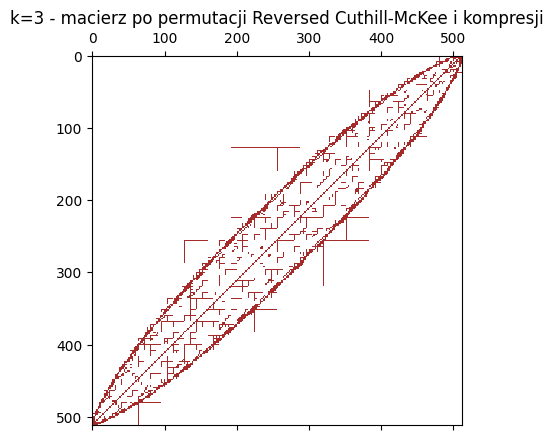

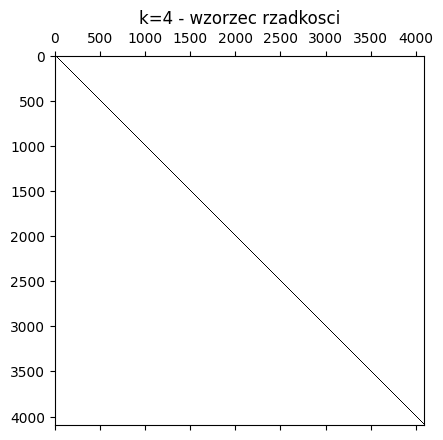

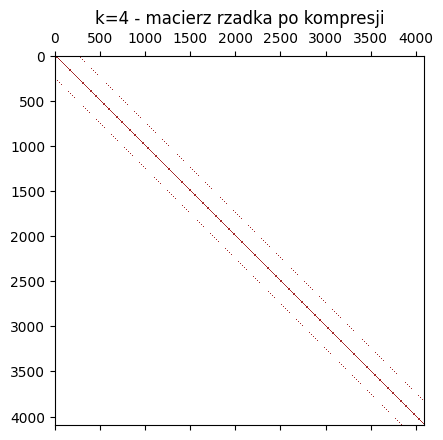

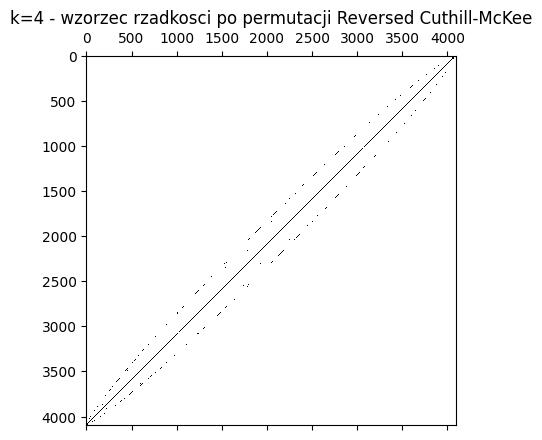

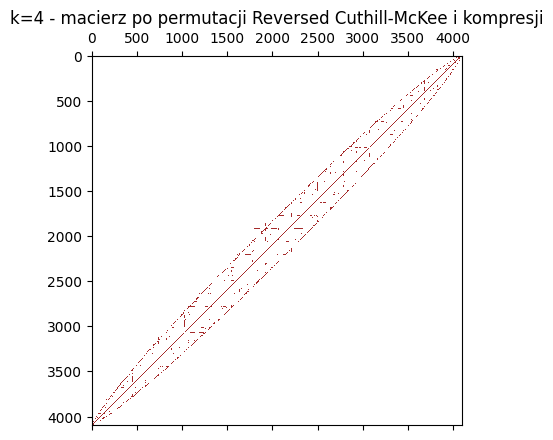

In [13]:
for k in [2, 3, 4]:
    matrix = create_3d_matrix(k)

    draw_matrix(matrix, f"k={k} - wzorzec rzadkosci")
    draw_node_matrix(compress(matrix, 1, 0.0000001),  f"k={k} - macierz rzadka po kompresji")

    matrix_after_permutation = reversed_cuthill_mckee_permuatation(matrix)

    draw_matrix(matrix_after_permutation, f"k={k} - wzorzec rzadkosci po permutacji Reversed Cuthill-McKee")
    draw_node_matrix(compress(matrix_after_permutation, 1, 0.0000001), f"k={k} - macierz po permutacji Reversed Cuthill-McKee i kompresji")